## Case file mapping

In [4]:
import os
import json
import tarfile
import pandas as pd

# Configuration
META_FILE = "OriginalData_from_GDC/metadata.cart.2025-08-24.json"
CLINICAL_TAR = "OriginalData_from_GDC/clinical.cart.2025-08-24.tar.gz"
OUT_DIR = "Data_results"
os.makedirs(OUT_DIR, exist_ok=True)

# Mode control
# True = keep only cases with all three modalities
# False = include all cases (missing modalities allowed)
REQUIRE_THREE_MODAL = False

# Load metadata
with open(META_FILE, "r") as f:
    metadata = json.load(f)
df = pd.json_normalize(metadata)
print(f"Loaded metadata entries: {len(df)}")

# Extract case_id
def extract_case_id(row):
    """Extract case_id from nested JSON fields."""
    if isinstance(row.get("associated_entities"), list):
        for e in row["associated_entities"]:
            if "case_id" in e:
                return e["case_id"]
    if isinstance(row.get("cases"), list):
        for c in row["cases"]:
            if "case_id" in c:
                return c["case_id"]
    for col in row.index:
        if "case_id" in col and pd.notna(row[col]):
            return row[col]
    return None

df["case_id"] = df.apply(extract_case_id, axis=1)
df = df.dropna(subset=["case_id"])

# Split by modality
rna_df = df[
    df["data_category"].str.contains("Transcriptome Profiling", case=False, na=False) &
    df["data_type"].str.contains("Gene Expression Quantification", case=False, na=False)
]
dna_df = df[
    df["data_category"].str.contains("Simple Nucleotide Variation", case=False, na=False) &
    df["data_type"].str.contains("Masked Somatic Mutation", case=False, na=False)
]
wsi_df = df[
    df["data_category"].str.contains("Biospecimen", case=False, na=False) &
    df["data_type"].str.contains("Slide Image", case=False, na=False)
]

# Build file mappings
def collect_file_map(sub_df):
    """Group files by case_id."""
    return (
        sub_df.groupby("case_id")["file_name"]
        .apply(lambda x: sorted(list(set(x.dropna()))))
        .to_dict()
    )

rna_map = collect_file_map(rna_df)
dna_map = collect_file_map(dna_df)
wsi_map = collect_file_map(wsi_df)

# Read clinical data
clinical_dfs = []
with tarfile.open(CLINICAL_TAR, "r:gz") as tar:
    for member in tar.getmembers():
        if member.name.endswith("clinical.tsv"):
            f = tar.extractfile(member)
            if f:
                clinical_dfs.append(pd.read_csv(f, sep="\t", dtype=str))

if not clinical_dfs:
    raise RuntimeError("❌ No 'clinical.tsv' found in the tar archive")
clinical_df = pd.concat(clinical_dfs, ignore_index=True)

# Select relevant columns
clinical_df = clinical_df[[
    c for c in clinical_df.columns
    if any(k in c.lower() for k in ["case_id", "submitter_id", "ajcc_pathologic_stage", "ajcc_pathologic_n", "ajcc_pathologic_t"])
]].drop_duplicates()

clinical_df = clinical_df.rename(columns={
    "cases.case_id": "case_id",
    "cases.submitter_id": "submitter_id",
    "diagnoses.ajcc_pathologic_stage": "AJCC_stage",
    "diagnoses.ajcc_pathologic_n": "AJCC_pathologic_N",
    "diagnoses.ajcc_pathologic_t": "AJCC_pathologic_T"
})

clinical_grouped = (
    clinical_df
    .groupby("case_id")
    .agg(lambda x: ";".join(sorted(set(x.dropna()))))
    .reset_index()
)
clinical_map = clinical_grouped.set_index("case_id").to_dict(orient="index")

# Determine case set
if REQUIRE_THREE_MODAL:
    case_set = set(rna_map) & set(dna_map) & set(wsi_map)
    print(f"Mode: 3-modality intersection, total {len(case_set)} cases")
else:
    case_set = set(rna_map) | set(dna_map) | set(wsi_map)
    print(f"Mode: full case union, total {len(case_set)} cases")

# Build mapping records
records, records_json = [], []

for cid in sorted(case_set):
    rna_files = rna_map.get(cid, [])
    dna_files = dna_map.get(cid, [])
    wsi_files = wsi_map.get(cid, [])
    clinical_info = clinical_map.get(cid, {})

    # CSV record
    records.append({
        "case_id": cid,
        "submitter_id": clinical_info.get("submitter_id", "NA"),
        "AJCC_stage": clinical_info.get("AJCC_stage", "NA"),
        "AJCC_pathologic_N": clinical_info.get("AJCC_pathologic_N", "NA"),
        "AJCC_pathologic_T": clinical_info.get("AJCC_pathologic_T", "NA"),
        "RNA_files": ";".join(rna_files) if rna_files else "NA",
        "DNA_files": ";".join(dna_files) if dna_files else "NA",
        "WSI_files": ";".join(wsi_files) if wsi_files else "NA",
    })

    # JSON record
    records_json.append({
        "case_id": cid,
        "submitter_id": clinical_info.get("submitter_id", "NA"),
        "AJCC_stage": clinical_info.get("AJCC_stage", "NA"),
        "AJCC_pathologic_N": clinical_info.get("AJCC_pathologic_N", "NA"),
        "AJCC_pathologic_T": clinical_info.get("AJCC_pathologic_T", "NA"),
        "RNA_files": rna_files or [],
        "DNA_files": dna_files or [],
        "WSI_files": wsi_files or [],
    })

# Save mapping outputs
csv_path = os.path.join(OUT_DIR, "case_file_mapping.csv")
pd.DataFrame(records).to_csv(csv_path, index=False)
print(f"CSV mapping saved: {csv_path}")

json_path = os.path.join(OUT_DIR, "case_file_mapping.json")
with open(json_path, "w") as f:
    json.dump(records_json, f, indent=2)
print(f"JSON mapping saved: {json_path}")

# Save modality manifests
def save_manifest(df, name):
    """Export manifest file for a given modality."""
    if df.empty:
        print(f"⚠️ {name} modality is empty, skipping manifest.")
        return
    manifest = df[["file_id", "file_name", "md5sum", "file_size", "state"]].rename(columns={
        "file_id": "id",
        "file_name": "filename",
        "md5sum": "md5",
        "file_size": "size"
    })
    path = os.path.join(OUT_DIR, f"{name}_manifest.txt")
    manifest.to_csv(path, sep="\t", index=False)
    print(f"{name} manifest saved: {path}")

# Filter manifests by selected case set
save_manifest(rna_df[rna_df["case_id"].isin(case_set)], "RNA")
save_manifest(dna_df[dna_df["case_id"].isin(case_set)], "DNA")
save_manifest(wsi_df[wsi_df["case_id"].isin(case_set)], "WSI")

Loaded metadata entries: 5335
Mode: full case union, total 1098 cases
CSV mapping saved: Data_results/case_file_mapping.csv
JSON mapping saved: Data_results/case_file_mapping.json
RNA manifest saved: Data_results/RNA_manifest.txt
DNA manifest saved: Data_results/DNA_manifest.txt
WSI manifest saved: Data_results/WSI_manifest.txt


## Download by API

In [ ]:
import os
import requests
import time
import pandas as pd

# Configuration
MANIFEST_PATH = "Data_results/RNA_manifest.txt"  # Path to your manifest file
DOWNLOAD_DIR = "TCGA_BRCA_RNA"                    # Output folder
RETRY_LIMIT = 5                                   # Max retry attempts per file

# Create download directory
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# Read manifest file
print("Reading manifest file ...")
df = pd.read_csv(MANIFEST_PATH, sep="\t")
print(f"Total files listed: {len(df)}")

# Initialize counters
skipped, success, failed = 0, 0, 0

# File download function
def download_file(file_id, filename):
    """Download a single file from GDC by file_id."""
    global skipped, success, failed
    url = f"https://api.gdc.cancer.gov/data/{file_id}"
    local_path = os.path.join(DOWNLOAD_DIR, filename)

    # Skip if already downloaded
    if os.path.exists(local_path):
        print(f"Already exists, skipping: {filename}")
        skipped += 1
        return

    # Retry loop
    for attempt in range(1, RETRY_LIMIT + 1):
        try:
            print(f"Downloading: {filename} (Attempt {attempt})")
            response = requests.get(url, stream=True, timeout=60)

            if response.status_code == 200:
                with open(local_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
                print(f"Download complete: {filename}")
                success += 1
                return
            else:
                print(f"Unexpected status code {response.status_code}: {filename}")
        except Exception as e:
            print(f"Network error: {e}, file: {filename}")

        time.sleep(2)  # Wait before retrying

    print(f"Failed after multiple attempts: {filename}")
    failed += 1

# Download all files
for i, row in df.iterrows():
    print(f"\nProgress: {i + 1}/{len(df)}")
    file_id = row.get("id") or row.get("file_id")
    filename = row.get("filename") or row.get("file_name")

    if not file_id or not filename:
        print("Skipped: Missing file_id or filename")
        continue

    download_file(file_id, filename)

# Summary report
print("\nDownload summary:")
print(f"Successfully downloaded: {success}")
print(f"Skipped (already exists): {skipped}")
print(f"Failed downloads: {failed}")

Reading manifest file ...
Total files listed: 1231

Progress: 1/1231
Already exists, skipping: 2e64abe2-6024-4d28-9e09-560ce2a9fd15.rna_seq.augmented_star_gene_counts.tsv

Progress: 2/1231
Already exists, skipping: 96a45a70-d4b5-4090-b603-73b7379679d6.rna_seq.augmented_star_gene_counts.tsv

Progress: 3/1231
Downloading: 1d468785-141d-40ca-acb1-d6d85a8c9d7b.rna_seq.augmented_star_gene_counts.tsv (Attempt 1)
Download complete: 1d468785-141d-40ca-acb1-d6d85a8c9d7b.rna_seq.augmented_star_gene_counts.tsv

Progress: 4/1231
Downloading: 748e4eaa-2b96-4dce-a903-c7df733d7f50.rna_seq.augmented_star_gene_counts.tsv (Attempt 1)
Download complete: 748e4eaa-2b96-4dce-a903-c7df733d7f50.rna_seq.augmented_star_gene_counts.tsv

Progress: 5/1231
Downloading: e614fbb4-7574-4704-9525-c0aea4c10fc6.rna_seq.augmented_star_gene_counts.tsv (Attempt 1)
Download complete: e614fbb4-7574-4704-9525-c0aea4c10fc6.rna_seq.augmented_star_gene_counts.tsv

Progress: 6/1231
Downloading: ad8c55ae-46df-43cd-8cb5-c049e3019959

## To H5ad file

In [ ]:
import os
import json
import re
import numpy as np
import pandas as pd
import anndata as ad

# Paths
rna_folder = "TCGA_BRCA_RNA"
mapping_path = "Data_results/case_file_mapping.json"
output_path = "TCGA_BRCA_RNA.h5ad"
os.makedirs(rna_folder, exist_ok=True)

# Step 1: Load case-to-file mapping
with open(mapping_path, "r") as f:
    mapping_data = json.load(f)

# Create case_id → info dict
mapping = {item["case_id"]: item for item in mapping_data if "case_id" in item}
print(f"Loaded mapping: {len(mapping)} cases")

# Step 2: Stage extraction function
def get_stage(info, strategy="max_stage"):
    raw_stage = info.get("AJCC_stage", "")
    stages = [s.strip() for s in re.split(r"[;|]", raw_stage) if "Stage" in s]

    stage_score = {"Stage I": 1, "Stage II": 2, "Stage III": 3, "Stage IV": 4}

    def simplify(stage):
        for key in sorted(stage_score.keys(), key=lambda x: -len(x)):
            if stage.startswith(key):
                return key
        return "Unknown"

    simplified = [simplify(s) for s in stages]
    filtered = [s for s in simplified if s in stage_score]

    if not filtered:
        return "Stage IV"

    if strategy in ["max_stage", "worst_progression"]:
        return max(filtered, key=lambda s: stage_score[s])
    elif strategy == "all_stages":
        return "|".join(sorted(set(filtered), key=lambda s: stage_score[s]))
    else:
        return "Stage IV"

# Step 3: Read and collect RNA expression files
rna_list = []
stage_labels = []
case_ids = []
seen_files = set()

for fname in os.listdir(rna_folder):
    if not fname.endswith(".tsv"):
        continue

    case_id = next(
        (cid for cid, info in mapping.items() if fname in info.get("RNA_files", [])), None
    )

    if case_id is None or fname in seen_files:
        continue
    seen_files.add(fname)
    file_path = os.path.join(rna_folder, fname)

    try:
        df = pd.read_csv(file_path, sep="\t", comment="#")
        col = next((c for c in ["tpm_unstranded", "unstranded", "FPKM", "raw_count"] if c in df.columns), df.columns[1])

        # Keep only standard ENSG gene entries
        df = df[df["gene_id"].astype(str).fillna("").str.startswith("ENSG")]
        df = df[["gene_name", col]].rename(columns={col: case_id}).set_index("gene_name")
        rna_list.append(df)

        # Extract stage label and patient ID
        stage_labels.append(get_stage(mapping[case_id], strategy="max_stage"))
        submitter_id = mapping[case_id].get("submitter_id", case_id)
        case_ids.append(submitter_id)

    except Exception as e:
        print(f"Failed to read {fname}: {e}")

print(f"Total valid samples: {len(case_ids)}")

# Step 4: Build expression matrix
rna_df = pd.concat(rna_list, axis=1)
rna_df = rna_df.fillna(0)
# rna_df = rna_df[rna_df.sum(axis=1) > 0]  # Remove genes with all-zero expression
rna_df.columns = pd.Index(rna_df.columns).astype(str)

X = rna_df.T.values
gene_names = list(rna_df.index.astype(str))

# Step 5: Create AnnData object
adata = ad.AnnData(X=X)
adata.var_names = gene_names
adata.obs["stage"] = stage_labels
adata.obs["patient_id"] = case_ids
adata.obs_names_make_unique()
adata.var_names_make_unique()

# Step 6: Sanity check
print("Sample obs_names:", adata.obs_names[:5])
print(f"Matrix shape: {adata.shape}")
# print("Last 5 gene names:", adata.var_names[-5:].tolist())
print("obs keys:", adata.obs.columns.tolist())
print("Stage distribution:\n", adata.obs["stage"].value_counts())

# Step 7: Save .h5ad file
adata.write(output_path)
print(f"Saved raw .h5ad to: {output_path}")

Loaded mapping: 1098 cases
Total valid samples: 1231
Sample obs_names: Index(['0', '1', '2', '3', '4'], dtype='object')
Matrix shape: (1231, 58048)
obs keys: ['stage', 'patient_id']
Stage distribution:
 stage
Stage II     705
Stage III    278
Stage I      201
Stage IV      47
Name: count, dtype: int64
Saved raw .h5ad to: TCGA_BRCA_RNA.h5ad


/var/folders/yy/s74n5fc53gv5mw5gdw5l8ch40000gn/T/ipykernel_36905/694566724.py:101: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`. Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  adata.var_names_make_unique()


## Data analysis

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1231 samples in 0.004s...
[t-SNE] Computed neighbors for 1231 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1231
[t-SNE] Computed conditional probabilities for sample 1231 / 1231
[t-SNE] Mean sigma: 6.854350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.708252
[t-SNE] KL divergence after 500 iterations: 1.761814


/var/folders/yy/s74n5fc53gv5mw5gdw5l8ch40000gn/T/ipykernel_36905/343459164.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stage_counts.index, y=stage_counts.values,


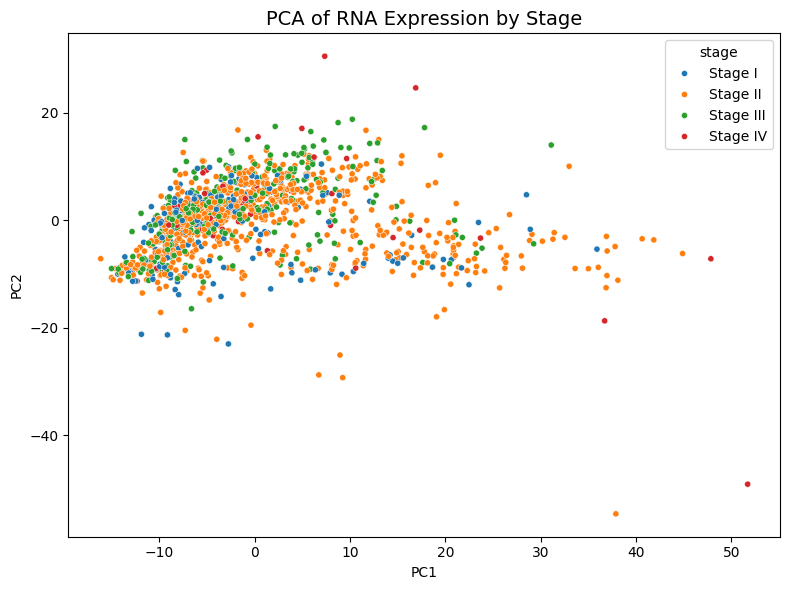

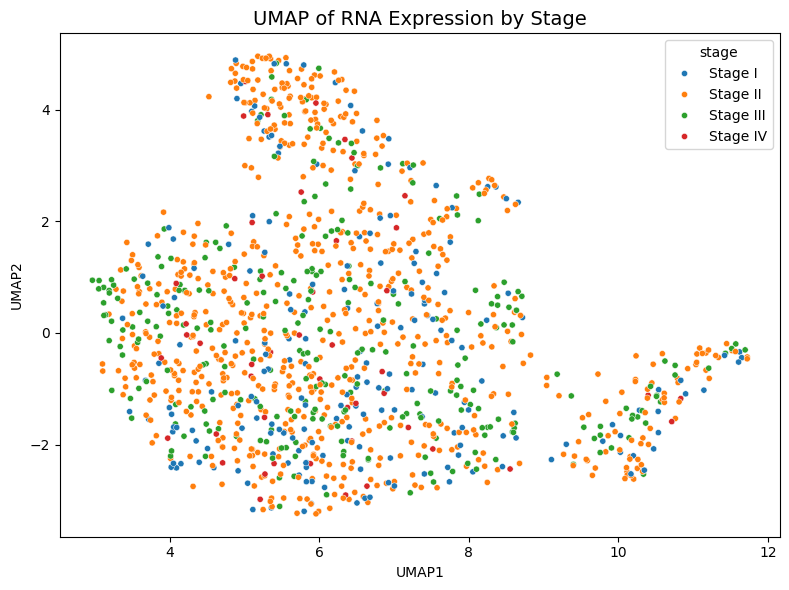

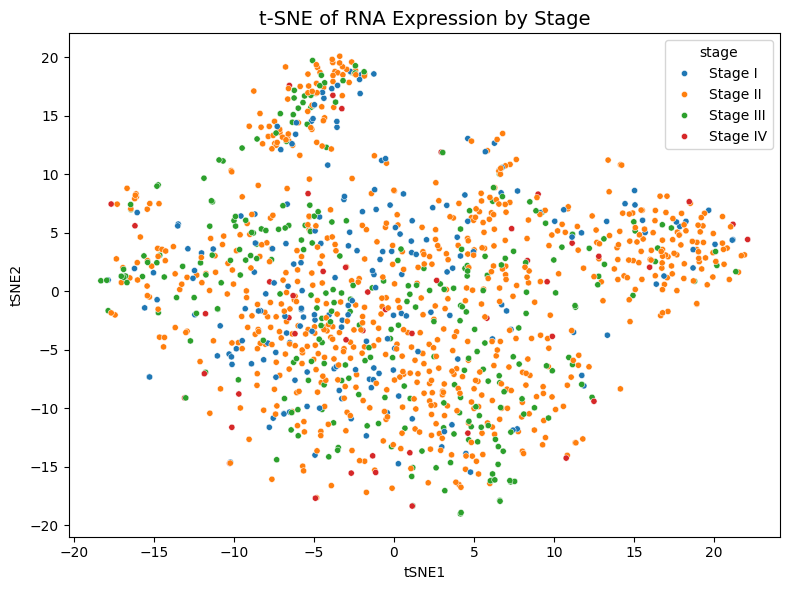

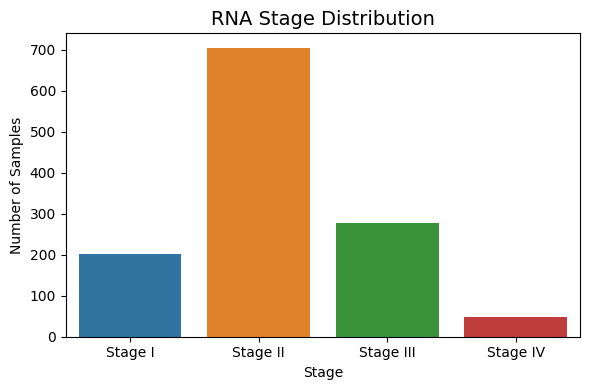

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from scipy.sparse import issparse
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Create output folder
# os.makedirs("figures", exist_ok=True)

# Step 0: Load data
adata = sc.read_h5ad("TCGA_BRCA_RNA.h5ad")

# Step 1: Extract matrix and labels
X = adata.X.toarray() if issparse(adata.X) else adata.X
stage_labels = adata.obs["stage"].values
label_map = {"Stage I": 0, "Stage II": 1, "Stage III": 2, "Stage IV": 3}
y = np.array([label_map.get(s, 3) for s in stage_labels])

# Step 2: Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Select top 1000 genes
selector = SelectKBest(score_func=f_classif, k=1000)
X_selected = selector.fit_transform(X_scaled, y)

# Define consistent color palette
stage_order = ["Stage I", "Stage II", "Stage III", "Stage IV"]
stage_palette = {
    "Stage I": "#1f77b4",   # blue
    "Stage II": "#ff7f0e",  # orange
    "Stage III": "#2ca02c", # green
    "Stage IV": "#d62728"   # red
}

# Step 4: PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_selected)
df_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df_pca["stage"] = stage_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="stage", hue_order=stage_order,
                palette=stage_palette, s=20)
plt.title("PCA of RNA Expression by Stage", fontsize=14)
plt.tight_layout()
# plt.savefig("figures/01_pca.png", dpi=300)
# plt.show()

# Step 5: UMAP
umap_result = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=42).fit_transform(X_selected)
df_umap = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
df_umap["stage"] = stage_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="stage", hue_order=stage_order,
                palette=stage_palette, s=20)
plt.title("UMAP of RNA Expression by Stage", fontsize=14)
plt.tight_layout()
# plt.savefig("figures/02_umap.png", dpi=300)
# plt.show()

# Step 6: t-SNE
tsne_result = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    max_iter=500,
    random_state=42,
    verbose=1
).fit_transform(X_selected)

df_tsne = pd.DataFrame(tsne_result, columns=["tSNE1", "tSNE2"])
df_tsne["stage"] = stage_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x="tSNE1", y="tSNE2", hue="stage", hue_order=stage_order,
                palette=stage_palette, s=20)
plt.title("t-SNE of RNA Expression by Stage", fontsize=14)
plt.tight_layout()
# plt.savefig("figures/03_tsne.png", dpi=300)
# plt.show()

# Step 7: Bar Plot
plt.figure(figsize=(6, 4))
stage_counts = pd.Series(stage_labels).value_counts().reindex(stage_order)
sns.barplot(x=stage_counts.index, y=stage_counts.values,
            palette=[stage_palette[stage] for stage in stage_counts.index])
plt.title("RNA Stage Distribution", fontsize=14)
plt.xlabel("Stage")
plt.ylabel("Number of Samples")
plt.tight_layout()
# plt.savefig("figures/04_stage_distribution.png", dpi=300)
# plt.show()